## init

In [289]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build.tools import sort as sort_atoms

import sys
sys.path.insert(0, '/root/git/hetcattoolbox')

from glob import glob
import pandas as pd
import numpy as np
import ast

In [291]:
from autoadsorbate.string_utils import _example_config, _show_ussage, construct_smiles, xx_get_special_symbols
from autoadsorbate.autoadsorbate import Fragment, Surface
from autoadsorbate.Surf import conformer_to_site
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O
from autoadsorbate.plotting import *

In [292]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager
plt.rcParams["font.family"] = "Arial"

## aads MACE relaxed intermediates

In [293]:
# # all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
# all_files = glob('./prep/relax/MACE*.xyz')
# len(all_files)

# rdf, relaxed_traj = read_relax_dir(all_files)
# _ = rdf.pop('site')
# rdf['origin'] = ['aads' for _ in rdf['uid']]

In [294]:
# from mace.calculators import mace_mp

# ref_atoms = relaxed_traj[0].copy()[[atom.index for atom in relaxed_traj[0] if atom.symbol == 'Cu']]
# calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
# ref_atoms.set_calculator(calc)
# parent_en = ref_atoms.get_potential_energy()

# ref_dict={
#     'C' : 0,
#     'O' : 0,
#     'H' : 0
# }

# # parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

# xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

### chemiscope

In [ ]:
# xdf = pd.read_csv('relaxed_traj.csv')
# relaxed_traj = read('relaxed_traj.xyz', index=':')

In [ ]:
# _xdf = filter_xdf(xdf, relaxed_traj)

In [ ]:
# len(_xdf.smiles.unique())

In [ ]:
# chemiscope.show(
#     frames=[relaxed_traj[i] for i in _xdf.traj_index.values],
#     properties=_xdf.to_dict(orient='list'),
#     mode='default',
# )

In [ ]:
chemiscope.write_input(
    frames=[center_fragment_in_cell(relaxed_traj[i], fragment_inds=[1]) for i in _xdf.traj_index.values],
    properties=_xdf.to_dict(orient='list'),
    path='chemiscope_input.json'
    # mode='default',
)

NameError: name 'chemiscope' is not defined

### plot atoms

In [ ]:
plot_most_stable(_xdf, relaxed_traj)

In [ ]:
make_hist_plot(_xdf)

In [ ]:
ax, heat_map = plot_energy_heatmap(_xdf,
                    column = 'energy_calibrated',
                    std = 0.05,
                    e_min=-0.1,
                    e_max=3,
                    resolution='auto',
                    normalize=True,
                    return_heatmap=True,
                    T=True,
                    cmap = "Blues"
                    )

In [ ]:
ax, heat_map = plot_energy_heatmap(_xdf,
                    column = 'energy_calibrated',
                    std = 0.05,
                    # e_max=_xdf.energy_calibrated.max()+5*std,
                    # e_min=_xdf.energy_calibrated.min()-5*std,
                    e_min=-0.1,
                    e_max=3,
                    resolution='auto',
                    normalize=False,
                    return_heatmap=True,
                    T=True)

In [ ]:
# sns.stripplot(
#     data=_xdf, x="total_bill", y="day", hue="time",
#     jitter=False, s=20, marker="D", linewidth=1, alpha=.1,
# )

## paper prep

In [ ]:
# # all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
# all_files = glob('./relax_*/MACE*.xyz')
# mpid=[[n for n in file.split('_') if 'mp-' in n][0] for file in all_files]
# pid =[[n for n in all_files[0].split('/') if '#' in n][0] for file in all_files]

# # rdf, relaxed_traj = read_relax_dir(all_files)
# # _ = rdf.pop('site')
# # rdf['origin'] = ['aads' for _ in rdf['uid']]

# # # rdf['mpid'] = mpid

In [ ]:
relaxed_traj = read('./collect_junwu/relaxed_traj.xyz', index=':')
rdf = pd.read_csv('./collect_junwu/data_rdf.csv')

_tmp = {}
for k in ast.literal_eval(rdf.slab_info.values[0]).keys():
    _tmp[k] = [ast.literal_eval(d)[k] for d in rdf.slab_info.values]
    rdf[k] = _tmp[k]

pid = rdf['mpid'] + '-' + rdf['mi'] + '-' + rdf['iterm'].astype(str) #[f"{ast.literal_eval(d)['mpid']}_{ast.literal_eval(d)['mi']}_{ast.literal_eval(d)['iterm']}" for d in rdf.slab_info.values]
rdf['pid'] = pid

In [ ]:
import json
with open('./collect_junwu/identifiers.json') as f:
    identifiers = json.load(f)
smiles = [i.split('--')[1] for i in identifiers]

In [ ]:
len(relaxed_traj) == len(rdf)

True

In [ ]:
len(rdf)

95741

In [ ]:
from mace.calculators import mace_mp

parent_en = {}
for pid in rdf.pid.unique():
    traj_index = rdf[rdf.pid.isin([pid])].traj_index.iloc[0]
    atoms = relaxed_traj[traj_index].copy()
    ref_atoms = atoms[[atom.index for atom in atoms if atoms.arrays['fragments'][atom.index] == 0]]
    calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
    ref_atoms.set_calculator(calc)
    parent_en[pid] = ref_atoms.get_potential_energy()
    ref_atoms.info={'pid': pid}

ref_dict={
    'C' : 0,
    'O' : 0,
    'H' : 0
}

# parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

/root/venvs/mace_env/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)
/root/venvs/mace_env/lib/python3.12/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  cell: Optional[Tensor] = torch.tensor(
/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/tmp/ipykernel_1089449/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


In [ ]:
bkp_xdf = xdf.copy()

In [ ]:
def plot_energy_heatmap(_xdf, column, std, e_min, e_max, resolution, normalize,
                        return_heatmap=False, T=False, cmap ='viridis', normalize_mode='max', ax=None):
    heat_map = []
    yticklabels = []
    

    for i, backbone in enumerate(_xdf.backbone.unique()):
        for j, H in enumerate(_xdf.H.unique()):
            df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
            if len(df_slice) > 0:
                v = energy_descriptor_from_slice(
                        df_slice,
                        column=column,
                        std=std,
                        e_min=e_min,
                        e_max=e_max,
                        resolution=resolution,
                        normalize=normalize,
                        normalize_mode=normalize_mode
                    )
                heat_map.append(v[1])  
                yticklabels.append(df_slice.calibrate_keys.values[0])
    heat_map = np.array(heat_map)

    xticklabels = []
    wanted_labels = np.arange(-10, 10, 0.4)
    for i, e in enumerate(v[0]):
        if any(np.abs(e - wanted_labels) < 1e-2):
            label = str(np.round(e, 1))
            if label not in xticklabels + ['-0.0']:
                xticklabels.append(label)
            else:
                xticklabels.append('')
            
        else:
            xticklabels.append('')

    if ax == None:
        fig = plt.figure()
        ax=fig.add_subplot(111)
    if T==False:
        sns.heatmap(heat_map, xticklabels=xticklabels, yticklabels=yticklabels, cbar=False, ax=ax)
        for i in range(heat_map.shape[0]+1):
            ax.axhline(i, color='white', lw=2 )
    
    else:
        ax = sns.heatmap(heat_map.T, xticklabels=yticklabels, yticklabels=xticklabels, cbar=False, cmap=cmap, ax=ax)   
        for i in range(heat_map.shape[1]+1):
            ax.axvline(i, color='white', lw=0.5)
    
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.invert_yaxis()
    
    if return_heatmap:
        return heat_map

## Figure SI

In [ ]:
xdf = bkp_xdf.copy()
# xdf = xdf[(xdf.material_formula == 'Cu') & xdf.mi.isin(['1#1#1','1#0#0'])]
_xdf = filter_xdf(xdf, relaxed_traj)

/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

remaining values in DF: 69876


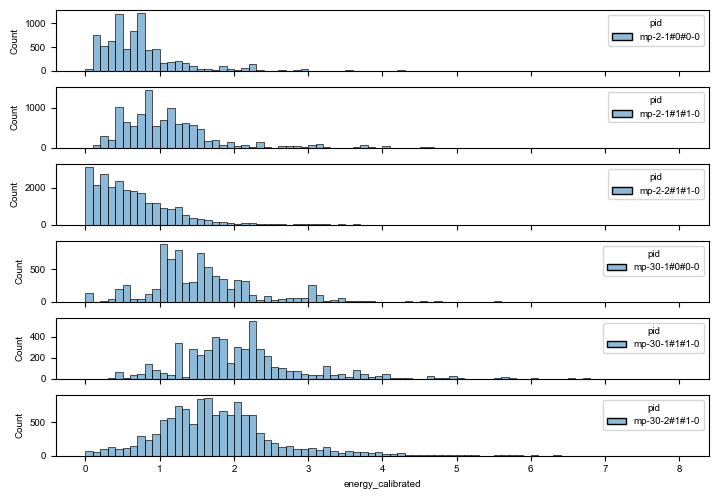

In [ ]:
font = {'size'   : 7}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(len(_xdf.pid.unique()), 1, figsize=[7.2,5], sharex=True)

for i, pid in enumerate(_xdf.pid.unique()):
    sns.histplot(_xdf[_xdf.pid==pid], x='energy_calibrated', hue='pid', ax=axs[i], binrange=[0,8], binwidth=0.1)

fig.set_layout_engine(layout='tight')
fig

In [ ]:
fig.savefig('figure_S_histogram.png', dpi=600)

In [ ]:
import itertools

# for mi in rdf.mi.unique()[:1]:
for metal in rdf.material_formula.unique():
# for mi, metal in list(itertools.product(rdf.mi.unique(), rdf.material_formula.unique()))[:]:
   
    print(mi)

    xdf = bkp_xdf.copy()
    # xdf = xdf[xdf.mi.isin([mi])]
    xdf = xdf[xdf.material_formula == metal]
    # xdf = xdf[(xdf.material_formula == metal) & xdf.mi.isin([mi])]
    _xdf = filter_xdf(xdf, relaxed_traj)

    fig, axs = plt.subplots(
        ncols=len(_xdf.H.unique()),
        nrows=len(_xdf.backbone.unique()),
        figsize=[7.2,8]
    )

    _xdf = _xdf.sort_values(by=['H', 'backbone'])

    view_atoms = []

    for i, backbone in enumerate(_xdf.backbone.unique()):
        for j, H in enumerate(_xdf.H.unique()):

            ax = axs[i,j]
            
            df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
            # df_slice.sort_values(by=['energy', 'backbone', 'H'],ascending=True)
            df_slice=df_slice[df_slice.energy==df_slice.energy.min()]
            
            if len(df_slice) > 0:
                e = np.round(df_slice.iloc[0].energy,2)
                origin = df_slice.iloc[0].origin
                traj_index = df_slice.iloc[0].traj_index
                
                atoms = relaxed_traj[traj_index].copy()
                atoms_center = get_fragment_center(atoms, fragment_index=1)
                atoms_center[2]=0
                half_cell = atoms.cell[1]*.5 + atoms.cell[0]*.5
                atoms.positions += - atoms_center + half_cell
                # atoms.positions += - atoms_center + (atoms.cell[0][0]+atoms.cell[1][0])*0.5 + (atoms.cell[0][1]+atoms.cell[1][1])*0.5
                atoms.wrap()
                # atoms.positions -= half_cell
                                
                plot_atoms(atoms, ax, rotation=('0x,0y,0z'), show_unit_cell=0)
                # ax.set_title(atoms.info['adsorbate_info']['smiles'], size=8)

                ax.set_title(df_slice.material_formula.iloc[0]+' '+f"({df_slice.mi.iloc[0].replace('#','')})", size=7)
                
            ax.set_axis_off()
            # x = cell[0][0] + cell[1][0]
            # y = cell[0][1] + cell[1][1]
            ax.set_xlim((atoms.cell[0][0]+atoms.cell[1][0])*0.5-2.5, (atoms.cell[0][0]+atoms.cell[1][0])*0.5+4.5)
            ax.set_ylim((atoms.cell[0][1]+atoms.cell[1][1])*0.5-2.1, (atoms.cell[0][1]+atoms.cell[1][1])*0.5+3.8)
            
            view_atoms.append(atoms)

    fig.set_layout_engine(layout='tight')

    # fig.savefig(f"figure_S_{metal}{mi.replace('#','')}_most_stable.png", dpi=600)
    # fig.savefig(f"figure_S_{mi.replace('#','')}_most_stable.png", dpi=600)
    fig.savefig(f"figure_S_{metal}_most_stable.png", dpi=600)
    # fig.savefig(f"figure_S_most_stable.png", dpi=600)
    
    

In [318]:
# fig

## figure MS

### fig2

In [ ]:
xdf = bkp_xdf.copy()
xdf = xdf[(xdf.material_formula == 'Pd') & xdf.mi.isin(['1#1#1'])]
_xdf = filter_xdf(xdf, relaxed_traj)

/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O


remaining values in DF: 10994


/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['plot_float'] = [
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
backbone_formulas = _xdf.backbone.unique()
width_ratios = [len(_xdf[_xdf.backbone.isin([bckbone])].calibrate_keys.unique()) for bckbone in backbone_formulas] 

fig, axs = plt.subplots(1, len(backbone_formulas), figsize=[7.2, 2], sharex=False, sharey=True,
                        gridspec_kw={'width_ratios': width_ratios}
                        )

num_dict = {}

for i, bckbone in enumerate(backbone_formulas):
    
    ax = axs[i]

    pdf = _xdf[_xdf.backbone.isin([bckbone])].copy()
    pdf = pdf.sort_values(by=['calibrate_keys'])

    calibrate_keys = []
    for k in pdf.calibrate_keys.values:
        k = k.replace('H0', '')
        k = k.replace('H1', 'H')
        k = k.replace('-', '')
        for n in [str(_n) for _n in range(10)]:
            k = k.replace(n, f'$_{n}$')
        calibrate_keys.append(k)
    
    pdf['calibrate_keys'] = calibrate_keys

    heat_map = plot_energy_heatmap(pdf,
                        column = 'energy_calibrated',
                        std = 0.05,
                        e_min=-0.2,
                        e_max=1.6,
                        resolution='auto',
                        normalize=True,
                        normalize_mode='max',
                        return_heatmap=True,
                        cmap='plasma',
                        T=True,
                        ax=ax)
    
        # ax.set_title(f"{pdf.material_formula.values[0]} ({mi.replace('#', '')})", fontdict = {'fontsize': 8})
    
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.tick_params("x", rotation=90)

    if i==0:
        ax.set_ylabel('E$_{ads}$ $_{rel}$ / eV', fontdict = {'fontsize': 7})
    num_dict[f"backbone"] = heat_map

fig.subplots_adjust(hspace=0.1, wspace=0.2)
fig.set_layout_engine(layout='tight')

In [ ]:
# fig, ax = plt.subplots(1,1)
# sns.heatmap(np.array([np.arange(-0.2, 1.6, 0.05/7)]).T, cmap='jet', ax=ax)
# fig


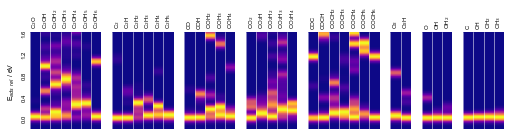

In [ ]:
fig

In [ ]:
fig.savefig('./energy_heatmap_Cu111_max.png', dpi=900)

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=[7.2, 3], sharex=False, sharey=False, gridspec_kw={'height_ratios': [1, 2.5]}, layout='compressed')

# e_is = [0.7, 0.5, 0.5, 0.2]
e_is = [[0.,0.2,0.6,0.7],[0.,0.1,.2,.6],[0,.2,.5,.7],[0,0.2,0.4,1.]]
perplexities = [20, 10, 15,15]

plot_trj = []

for j, ck in enumerate(['C2O-H4', 'CO-H2', 'CO2-H2', 'COC-H4']):
    ax = axs[0, j]
    pdf = _xdf[_xdf.calibrate_keys.isin([ck])].copy()

    # for e in pdf.energy_calibrated.values:
    e = pdf.energy_calibrated.values
    energy_range, energy_values = get_gaussian_vectors(e, std = 0.05, e_min = -0.2, e_max = 1.6, resolution=0.001, normalize=True, normalize_mode='max')

    print(len(e[e<1.6]))
    for e_i in e[e<1.6]:
        i = find_index_by_energy(e_i, energy_range)
        ax.plot([energy_range[i], energy_range[i]], [energy_values[i], -1], linewidth=0.3, color='#ccccccff', alpha=0.6, zorder=0)
    ax.plot(energy_range, energy_values, color='#ccccccff', alpha=1,zorder=0)
    sns.scatterplot(x=energy_range, y=energy_values, hue=energy_values, alpha=1, ax=ax, legend=False, palette='plasma', markers='o', s=5, linewidth=0)
    
    # i = np.where(energy_values == np.max(energy_values))[0][0]
    # e_i = energy_values[i]
    # i = find_index_by_energy(e_i, pdf.energy_calibrated.values, _thr=0.3)
    # e_i = pdf.energy_calibrated.values[i]
    # i = find_index_by_energy(e_i, energy_range)
    # ax.plot([energy_range[i], energy_range[i]], [energy_values[i], -1], linewidth=0.5, color='black', alpha=1, zorder=10, marker='o', markersize=2)

    
    _pdf = pdf[pdf['energy_calibrated']==pdf['energy_calibrated'].min()]
    # plot_trj.append(relaxed_traj[_pdf.traj_index.values[0]])
    
    # e_i = _pdf.energy_calibrated.values[0]
    # i = find_index_by_energy(e_i, energy_range)
    # ax.plot([energy_range[i], energy_range[i]], [energy_values[i], -1], linewidth=0.5, color='black', alpha=1, zorder=10, marker='o', markersize=5)
    
    for x in e_is[j]:
        _pdf = pdf[pdf.energy_calibrated > x]
        _pdf = _pdf[_pdf['energy_calibrated']==_pdf['energy_calibrated'].min()]
        
        e_i = _pdf.energy_calibrated.values[0]
        
        smiles = _pdf.smiles.values[0]
        _a = relaxed_traj[_pdf.traj_index.values[0]].copy()
        _a.info['smiles'] = smiles
        plot_trj.append(_a)

        i = find_index_by_energy(e_i, energy_range)
        ax.plot([energy_range[i], energy_range[i]], [energy_values[i], -1], linewidth=0.5, color='black', alpha=1, zorder=20, marker='x', markersize=5, mfc='none')
    

    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=2)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    ax.set_xlabel('E$_{ads}$ $_{rel}$ / eV', fontdict = {'fontsize': 7})
    if j == 0:
        ax.set_ylabel('DOS$_{ads}$', fontdict = {'fontsize': 7})
    ax.get_yaxis().set_ticklabels([])
    ax.set_ylim([-0.01, 1.1])
    ax.set_xlim([-0.2, 1.6])

    ax = axs[1, j]
    c_trj = [relaxed_traj[i] for i in pdf.traj_index.values]    
    X_2d = get_tsne_from_traj(c_trj, perplexity=perplexities[j])
    
    x=X_2d[:,0]
    y=X_2d[:,1]
    z=pdf.energy_calibrated.values
    points = ax.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.7, linewidth=0.7, vmin=0, vmax=1.6, edgecolors='black')
    
    
    ax.set_xlabel('TNSE$_{1}$', fontdict = {'fontsize': 7})
    if j == 0:
        ax.set_ylabel('TNSE$_{2}$', fontdict = {'fontsize': 7})
    ax.set_box_aspect(aspect=1)
    ax.tick_params(axis='both', which='both', length=0)
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    

fig.subplots_adjust(hspace=0.0, wspace=0.05)
fig.set_layout_engine(layout='tight')

# cbar = fig.colorbar(points, ax=[axs[1,n] for n in [0,1,2,3]], orientation='vertical', location='right', shrink=0.6)
# cbar.set_label('E$_{ads}$ $_{rel}$ / eV', fontsize=6)
# ticklabs = cbar.ax.get_yticklabels()
# cbar.ax.set_yticklabels(ticklabs, fontsize=6)


214
98
157
133


/tmp/ipykernel_1089449/4000127771.py:85: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.0, wspace=0.05)


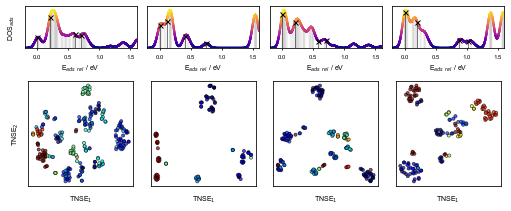

In [ ]:
fig

In [ ]:
fig.savefig('./energy_heatmap_Cu111_max_pt2.png', dpi=900)

In [ ]:
for a in plot_trj[0:4]:
    print(a.info['smiles'])

S1SOC1C
Cl[OH+][CH-][CH2]
Cl[OH+][C]C
Cl[OH+][C]C


In [ ]:
view(plot_trj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

In [ ]:
blend_trj = []
for atoms in plot_trj:
    a = atoms.copy()
    shift = atoms.cell[0]*0.4 + atoms.cell[1]*0.4
    cms = a[[atom.index for atom in a if a.arrays['fragments'][atom.index] > 0]].get_center_of_mass()
    cms[2] = 0
    a.positions += shift - cms
    a.wrap()
    blend_trj.append(a)

view(blend_trj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

In [ ]:
xx_trj = []
for s in ['S1SCC1O']:
    _xx = rdf[rdf.smiles==s]
    for idx in _xx.traj_index:
        xx_trj.append(relaxed_traj[idx].copy())

view(xx_trj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

In [ ]:

from autoadsorbate.utils import get_blenderized

In [ ]:
bt= get_blenderized(blend_trj, scale=[3, 1, 1], hide_spot=[0,0,0])
write('blenderized_fig2.xyz', bt)

bt= get_blenderized(blend_trj, scale=[1, 3, 1], hide_spot=[0,0,0])
write('blenderized_fig2_b.xyz', bt)

In [ ]:
view(bt)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

### fig3

In [ ]:
xdf = bkp_xdf.copy()
# xdf = xdf[(xdf.material_formula == 'Cu') & xdf.mi.isin(['1#1#1','1#0#0'])]
_xdf = filter_xdf(xdf, relaxed_traj)

/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/root/venvs/mace_env/lib/python3.12/site-packages/autoadsorbate/plotting.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

remaining values in DF: 69876


In [ ]:
# _xdf = bkp_xdf.copy()
mis = ['1#1#1','1#0#0', '2#1#1']#_xdf.mi.unique()
# mpids = _xdf.mpid.unique()
mpids = ['mp-30', 'mp-2']#_xdf.mpid.unique()

fig, axs = plt.subplots(len(mis), len(mpids), figsize=[7.2, 173/25.4], sharex=True, sharey=True)

num_dict = {}

for i, mpid in enumerate(mpids):
    for j, mi in enumerate(mis):

        pdf = _xdf[_xdf.mi.isin([mi]) & _xdf.mpid.isin([mpid])].copy()
        pdf = pdf.sort_values(by=['calibrate_keys'])

        calibrate_keys = []
        for k in pdf.calibrate_keys.values:
            k = k.replace('H0', '')
            k = k.replace('H1', 'H')
            k = k.replace('-', '')
            for n in [str(_n) for _n in range(10)]:
                k = k.replace(n, f'$_{n}$')
            calibrate_keys.append(k)
        pdf['calibrate_keys'] = calibrate_keys

        if len(mpids) == 1:
            ax = axs[j]
        else:
            ax = axs[j,i]
            
        heat_map = plot_energy_heatmap(pdf,
                            column = 'energy_calibrated',
                            std = 0.05,
                            e_min=-0.1,
                            e_max=3,
                            resolution='auto',
                            normalize=True,
                            normalize_mode='max',
                            return_heatmap=True,
                            cmap='plasma',
                            T=True,
                            ax=ax)
        ax.set_title(f"{pdf.material_formula.values[0]} ({mi.replace('#', '')})", fontdict = {'fontsize': 8})
        if i == 0:
            ax.set_ylabel('E$_{ads}$ $_{rel}$ / eV', fontdict = {'fontsize': 7})
        num_dict[f"{mpid}_{mi}_0"] = heat_map

fig.subplots_adjust(hspace=0.1, wspace=0.2)
fig.set_layout_engine(layout='tight')

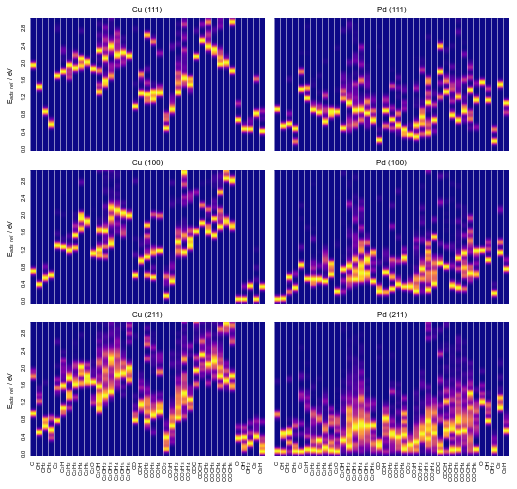

In [ ]:
fig

In [ ]:
fig.savefig('./figure3.png', dpi=900)

In [ ]:
def plot_energy_heatmap_smiles(_xdf, column, std, e_min, e_max, resolution, normalize,
                        return_heatmap=False, T=False, cmap ='viridis', normalize_mode='max', ax=None):
    
    heat_map = []
    yticklabels = []
    
    for i, smiles in enumerate(_xdf.smiles.unique()):
        df_slice = _xdf[_xdf.smiles.isin([smiles])]
        if len(df_slice) > 0:
            v = energy_descriptor_from_slice(
                    df_slice,
                    column=column,
                    std=std,
                    e_min=e_min,
                    e_max=e_max,
                    resolution=resolution,
                    normalize=normalize,
                    normalize_mode=normalize_mode
                )
            heat_map.append(v[1])  
            yticklabels.append(smiles)
    heat_map = np.array(heat_map)

    xticklabels = []
    wanted_labels = np.arange(-10, 10, 0.4)
    for i, e in enumerate(v[0]):
        if any(np.abs(e - wanted_labels) < 1e-2):
            label = str(np.round(e, 1))
            if label not in xticklabels + ['-0.0']:
                xticklabels.append(label)
            else:
                xticklabels.append('')
            
        else:
            xticklabels.append('')

    if ax == None:
        fig = plt.figure()
        ax=fig.add_subplot(111)
    if T==False:
        sns.heatmap(heat_map, xticklabels=xticklabels, yticklabels=yticklabels, cbar=False, ax=ax)
        for i in range(heat_map.shape[0]+1):
            ax.axhline(i, color='white', lw=2 )
    
    else:
        ax = sns.heatmap(heat_map.T, xticklabels=yticklabels, yticklabels=xticklabels, cbar=False, cmap=cmap, ax=ax)   
        for i in range(heat_map.shape[1]+1):
            ax.axvline(i, color='white', lw=0.5)
    
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.invert_yaxis()
    
    if return_heatmap:
        return heat_map

In [ ]:
pdf = _xdf[(_xdf.calibrate_keys == 'C2O-H4')].copy()

sort_keys = {}
for smiles in pdf.smiles.unique():
    sort_keys[smiles] = pdf[pdf.smiles==smiles].energy_calibrated.min()


pdf['sort_plot_en'] = [sort_keys[smiles] for smiles in pdf.smiles.values]
pdf = pdf.sort_values(by=['sort_plot_en'])

pdf = pdf[pdf.sort_plot_en < 1.5]

In [ ]:
len(pdf.smiles.unique())

46

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[7.2, 2.5], sharex=False, sharey=True,
                        # gridspec_kw={'width_ratios': width_ratios}
                        )
plot_energy_heatmap_smiles(pdf.sort_values(by=['energy_calibrated']), column='energy_calibrated', std = 0.05, e_min = -0.2,
                           e_max = 1.6, resolution=0.001, normalize=True, normalize_mode='integral', return_heatmap=False, T=True, cmap ='plasma', ax = ax)

ax.set_ylabel('E$_{ads}$ $_{rel}$ / eV', fontdict = {'fontsize': 7})
fig.subplots_adjust(hspace=0.0, wspace=0.05)
fig.set_layout_engine(layout='tight')

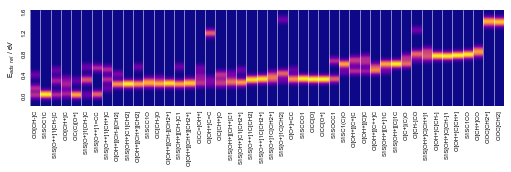

In [ ]:
fig

In [ ]:
fig.savefig('./energy_heatmap_Cu111_max_pt3.png', dpi=900, transparent=True)

In [ ]:
from dscribe.descriptors import SOAP
from sklearn.manifold import TSNE

def get_tsne_from_traj(c_trj, perplexity=20.0):
    species = list(set([atom.symbol for atom in c_trj[0]]))
    r_cut = 6.0
    n_max = 8
    l_max = 6

    # Setting up the SOAP descriptor
    soap = SOAP(
        species=species,
        periodic=True,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
    )


    soap_desc = [soap.create(a) for a in c_trj]

    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)

    X_2d = tsne.fit_transform(np.array(soap_desc).reshape(len(soap_desc), -1))

    return X_2d

def find_index_by_energy(e_i, energy_range, _thr=0.01):
    index_candidates = np.where(np.abs(energy_range - e_i)<_thr)[0]
    while len(index_candidates) > 1:
        # print(_thr, len(index_candidates))
        _thr-=0.000001
        index_candidates = np.where(np.abs(energy_range - e_i)<_thr)[0]
    index = index_candidates[0]
    return index

e_i = e[10]
# energy_range[find_index_by_energy(e_i, energy_range)]




### figure 1 pt2

In [324]:
import os
# import json
# import numpy as np
# from ase.io import read

path = './collect_junwu/'

# with open(os.path.join(path, 'identifiers.json')) as f:
#     identifiers = json.load(f)

# energy_array = np.load(os.path.join(path, 'energy_array.npy'))
# smiles = [i.split('--')[1] for i in identifiers]
# pid = [i.split('--')[0].split('elax_')[-1] for i in identifiers]
# relaxed_traj = read(os.path.join(path, 'relaxed_traj.xyz'), index=':')
parent_traj = read(os.path.join(path, 'parent_traj.xyz'), index=':')

In [ ]:
view(parent_traj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/root/venvs/mace_env/lib/python3.12/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/root/venvs/mace_env/lib/python3.12/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/root/venvs/mace_env/lib/python3.12/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/venvs/mace_env/lib/python3.12/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/root/venvs/mace_env/lib/python3.12/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


In [ ]:
atoms = parent_traj[0].copy()
s= Surface(atoms)
s.sym_reduce()

In [365]:
x_trj = []

for atoms in parent_traj:
    s= Surface(atoms)
    s.sym_reduce()


    for i in s.site_df.index.values:
        site_marker = s.view_site(i, return_atoms=True) 

        for atom in site_marker:
            if atom.symbol in ['Cu', 'Pd']:
                atom.symbol = 'Zn'
            if atom.symbol =='X':
                atom.symbol = 'He'
        
        x_atoms= s.atoms.copy()
        x_atoms +=site_marker
        he_cms = x_atoms[[atom.index for atom in x_atoms if atom.symbol =='He']].get_center_of_mass()
        x_atoms.positions = x_atoms.positions + atoms.cell[0]*0.5 + atoms.cell[1]*0.5 - he_cms 
        x_atoms.wrap()
        he_cms = x_atoms[[atom.index for atom in x_atoms if atom.symbol =='He']].get_center_of_mass()
        he_cms[2]=0
        x_atoms*=[3,3,1]
        x_atoms.positions -= he_cms
        
        x_trj .append(x_atoms)

view(x_trj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

In [363]:
view(x_trj)

<Popen: returncode: None args: ['/root/venvs/mace_env/bin/python', '-m', 'as...>

In [ ]:
bt = get_blenderized(x_trj, scale=[1,1,1], hide_spot=[-50,0,0])
write('sites.xyz', bt)